In [140]:
"""
TODO
    # - parameter tuning for models
    # - feature engineering
    # - improve the comments and explanations
    # - Add the final summary [ Conclusions and Recommendations ]
"""

# Acquire Knowledge

## Explore Problem

Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted inspiration, so they decided to provide it. Started life as a search engine for recipes, helping people to find ways to use up the limited supplies they had at home. Now, over two years on, they are a fully fledged business. For a monthly subscription they will put together a full meal plan to ensure you and your family are getting a healthy, balanced diet whatever your budget.

At the moment, They choose a favorite recipe from a selection and display that on the home page. They have noticed that traffic to the rest of the website goes up by as much as 40% if they pick a popular recipe. More traffic means more subscriptions so this is really important to the company.

Our goal is:
   - Predict which recipes will lead to high traffic?
   - Correctly predict high traffic recipes 80% of the time?

Our written report should include written text summaries and graphics of the following:
 - Data validation:
    - Describe validation and cleaning steps for every column in the data
 - Exploratory Analysis to answer the customer questions ensuring you include:
    - Two different types of graphic showing single variables only
    - At least one graphic showing two or more variables
    - Description of your findings
 - Model Development including:
    - What type of problem this is
    - Fitting a baseline model
    - Fitting a comparison model
 - Model evaluation
    - Show how the two models compare
 - Definition of a metric for the business to monitor
    - How should the business monitor what they want to achieve?
    - Estimate the initial value(s) for the metric based on the current data?
 - Final summary including recommendations that the business should undertake

## Data Description

The product manager has tried to make this easier for us and provided data for each recipe, as well as whether there was high traffic when the recipe was featured on the home page. The data is in the file recipe_site_traffic_2212.csv. The data contains the following columns:

| Column | Description |
| --- | --- |
| recipe_id | The unique identifier for the recipe |
| category | The category of the recipe |
| servings | The number of servings the recipe makes |
| calories | The number of calories per serving |
| carbohydrate | The number of grams of carbohydrates per serving |
| protein | The number of grams of protein per serving |
| sugar | The number of grams of sugar per serving |
| high_traffic | Whether the recipe was featured on the home page when there was high traffic (1) or not (0) |




# Data Preparation
After uploading the data it was found that it contains 52 NaN values in calories, carbohydrate, sugar, protein.

I tried to use KNN imputer, however it didn't work out well, so I abandoned the idea as the results of the model turned out to be worse, so the decision was to drop 52 missing rows.

High traffic also has missing values but in this case, it is not missing at random, so I just replaced NA values with 'Low'.

Backlog of changes:
calories - NA rows, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax
carbohydrate - NA rows dropped, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax
sugar - NA rows dropped, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax
protein - NA rows dropped, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax
category - 'Chicken Breast' values for changed to 'Chicken',
then columns were one hot encoded servings - 2 values contained 'as a snack',
they belonged to Lunch/Snack category so 'as a snack' was removed, the column was transformed to float 64
high_traffic - NaN values were replaced with 'not high' and then changed to 1 - high, 0 - not high

## Imports

In [123]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pylab import rcParams
from scipy.stats import stats
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, \
    recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from xgboost import XGBClassifier

rcParams['figure.figsize'] = 20, 10

import warnings

warnings.filterwarnings('ignore')

## Data Exploration

In [55]:
df = pd.read_csv('recipe_site_traffic_2212.csv')

In [56]:
df.shape

(947, 8)

In [57]:
df.dtypes

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

In [58]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [60]:
df.describe(include='all')

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


In [61]:
# split columns into categorical and numeric
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
numeric_columns = [col for col in df.columns if df[col].dtype == 'float64']

In [62]:
# check unique values in each categorical column
for col in df[categorical_columns]:
    print(f'{col}: {df[col].unique()}')

category: ['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']
servings: ['6' '4' '1' '2' '4 as a snack' '6 as a snack']
high_traffic: ['High' nan]


In [63]:
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [64]:
# check for duplicates
df.duplicated().any()

False

## Data Cleaning

In [65]:
# fill missing values in high_traffic column with 'Low'
df['high_traffic'].fillna('Low', inplace=True)

In [66]:
# filling missing values in numeric columns with mean
df['calories'].fillna(df['calories'].mean(), inplace=True)
df['protein'].fillna(df['protein'].mean(), inplace=True)
df['carbohydrate'].fillna(df['carbohydrate'].mean(), inplace=True)
df['sugar'].fillna(df['sugar'].mean(), inplace=True)

In [67]:
# replace ' as a snack' with '' in servings column
df['servings'] = df['servings'].str.replace(' as a snack', '')

In [68]:
# replace 'Chicken Breast' with 'Chicken' in category column
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')

In [69]:
df.isnull().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

## Data Analysis and Visualization

Through the utilization of distplot to inspect the distribution of calories, carbohydrates, sugar, and protein, I discovered that all of them are skewed to the left.

This information is important because it can have an impact on the performance of our models. A left-skewed distribution may cause issues with particular statistical tests and models, such as logistic regression, that assume data has a normal distribution.

### Detect Outliers


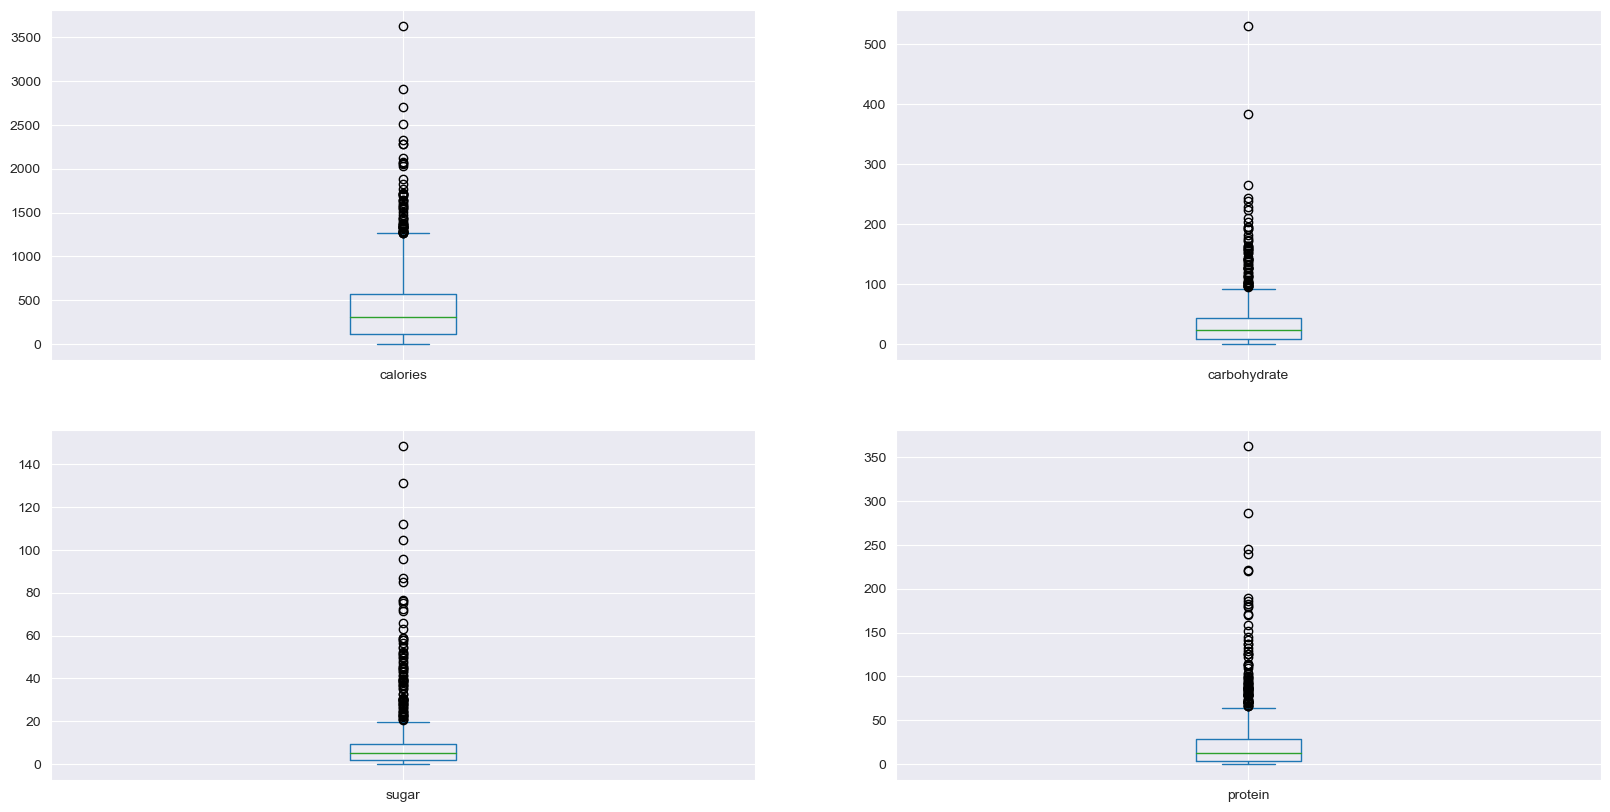

In [70]:
# box plot for each numeric column in grid
df[numeric_columns].plot(kind='box', subplots=True, layout=(2, 2), sharex=False, sharey=False)
plt.show()

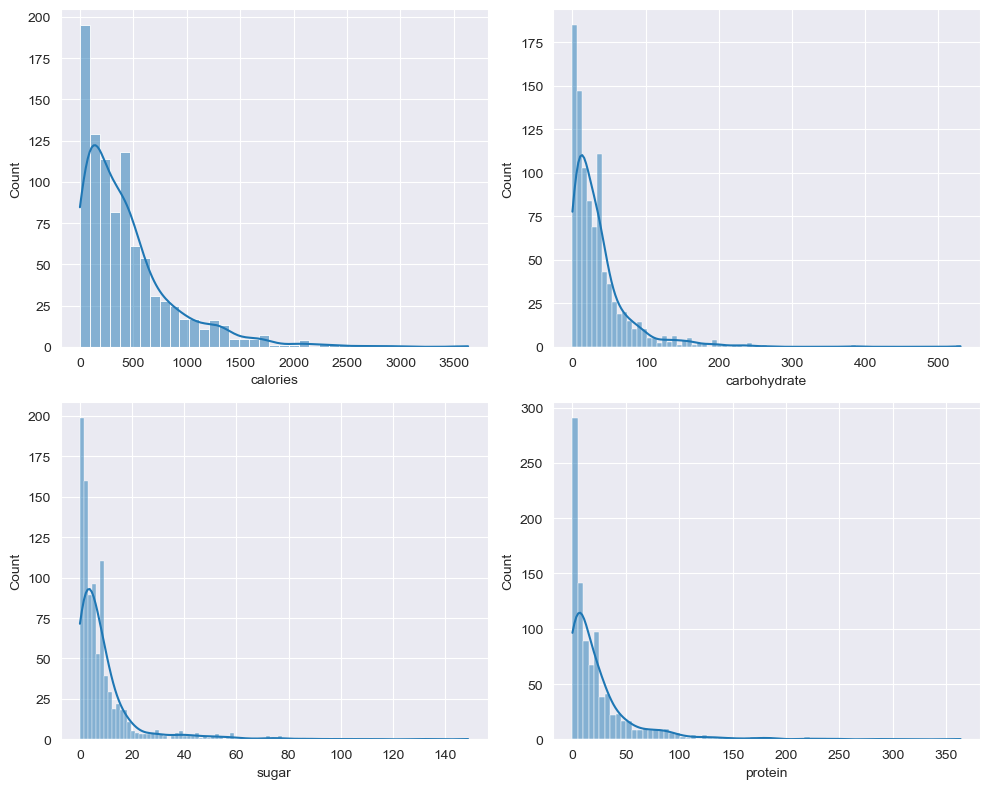

In [71]:
# Plot histograms of calories, carbohydrates, sugar, and protein
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(df, x="calories", kde=True, ax=axs[0, 0])
sns.histplot(df, x="carbohydrate", kde=True, ax=axs[0, 1])
sns.histplot(df, x="sugar", kde=True, ax=axs[1, 0])
sns.histplot(df, x="protein", kde=True, ax=axs[1, 1])
plt.tight_layout()
plt.show()


### Correlation
There is a strong positive correlation (0.17) between calories and protein, which means that as one variable increases, the other variable tends to increase as well. There is also a weak negative correlation (-0.03) between calories and carbohydrate, which means that as one variable increases, the other variable tends to decrease slightly.

In [72]:
corr = df[numeric_columns].corr()
corr

,calories,carbohydrate,sugar,protein
calories,1.000000,-0.028970,-0.097302,0.172477
carbohydrate,-0.028970,1.000000,0.073922,-0.042795
sugar,-0.097302,0.073922,1.000000,-0.099053
protein,0.172477,-0.042795,-0.099053,1.000000


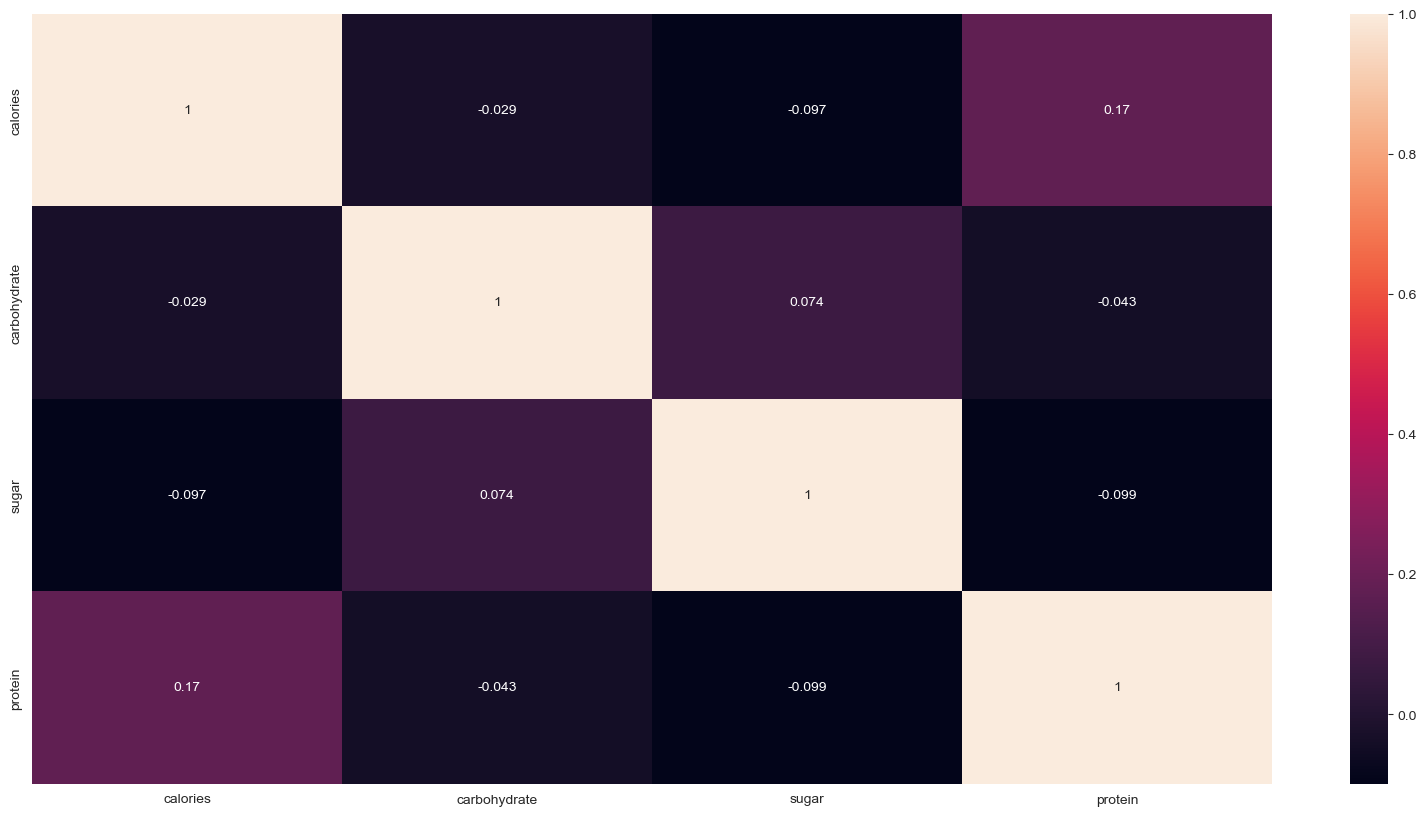

In [73]:
sns.heatmap(corr, annot=True)
plt.show()

### Statistics
The null hypothesis for each of these tests is that there is no difference between the means of the two groups (high and low traffic recipes). If the p-value is less than the significance level (usually 0.05), then we reject the null hypothesis and conclude that there is a significant difference between the means of the two groups.

The p-values for calories, carbohydrate, and sugar are less than 0.05, which means that we can reject the null hypothesis and conclude that there is a significant difference between the means of these variables in high and low traffic recipes.

However, the p-value for protein is greater than 0.05, which means that we cannot reject the null hypothesis and conclude that there is no significant difference between the means of protein in high and low traffic recipes

This means that the mean of calories, carbohydrate and sugar are different between high and low traffic recipes, but the mean of protein is the same between high and low traffic recipes.

In [74]:
# calculate the statistical test which is t-test to compare the means of the nutritional information between the high and low traffic recipes, and see if there are significant differences.
for col in numeric_columns:
    print(f'{col}: {stats.ttest_ind(df[df["high_traffic"] == "High"][col], df[df["high_traffic"] == "Low"][col])}')

calories: Ttest_indResult(statistic=2.2367209602372866, pvalue=0.02553717821157609)
carbohydrate: Ttest_indResult(statistic=2.434859270974101, pvalue=0.015081724039154148)
sugar: Ttest_indResult(statistic=-2.2713357370753844, pvalue=0.023350838870939146)
protein: Ttest_indResult(statistic=1.338132254665393, pvalue=0.1811752148589351)


### Categorical Features

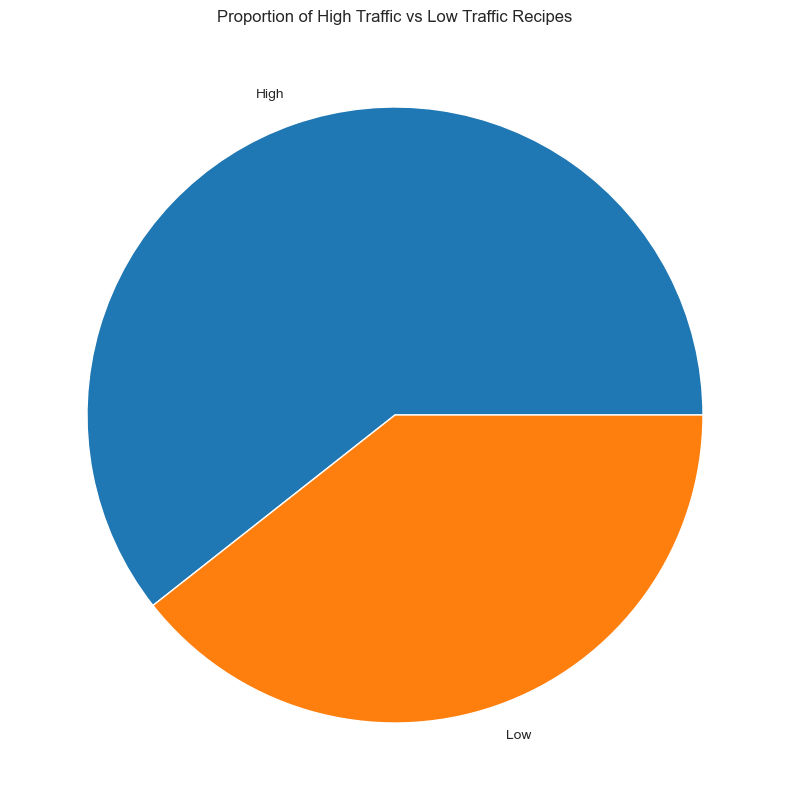

In [75]:
# Calculate proportion of high traffic vs low traffic recipes
traffic_counts = df['high_traffic'].value_counts()

# Create a pie chart
plt.pie(traffic_counts.values, labels=traffic_counts.index)
plt.title('Proportion of High Traffic vs Low Traffic Recipes')
plt.show()

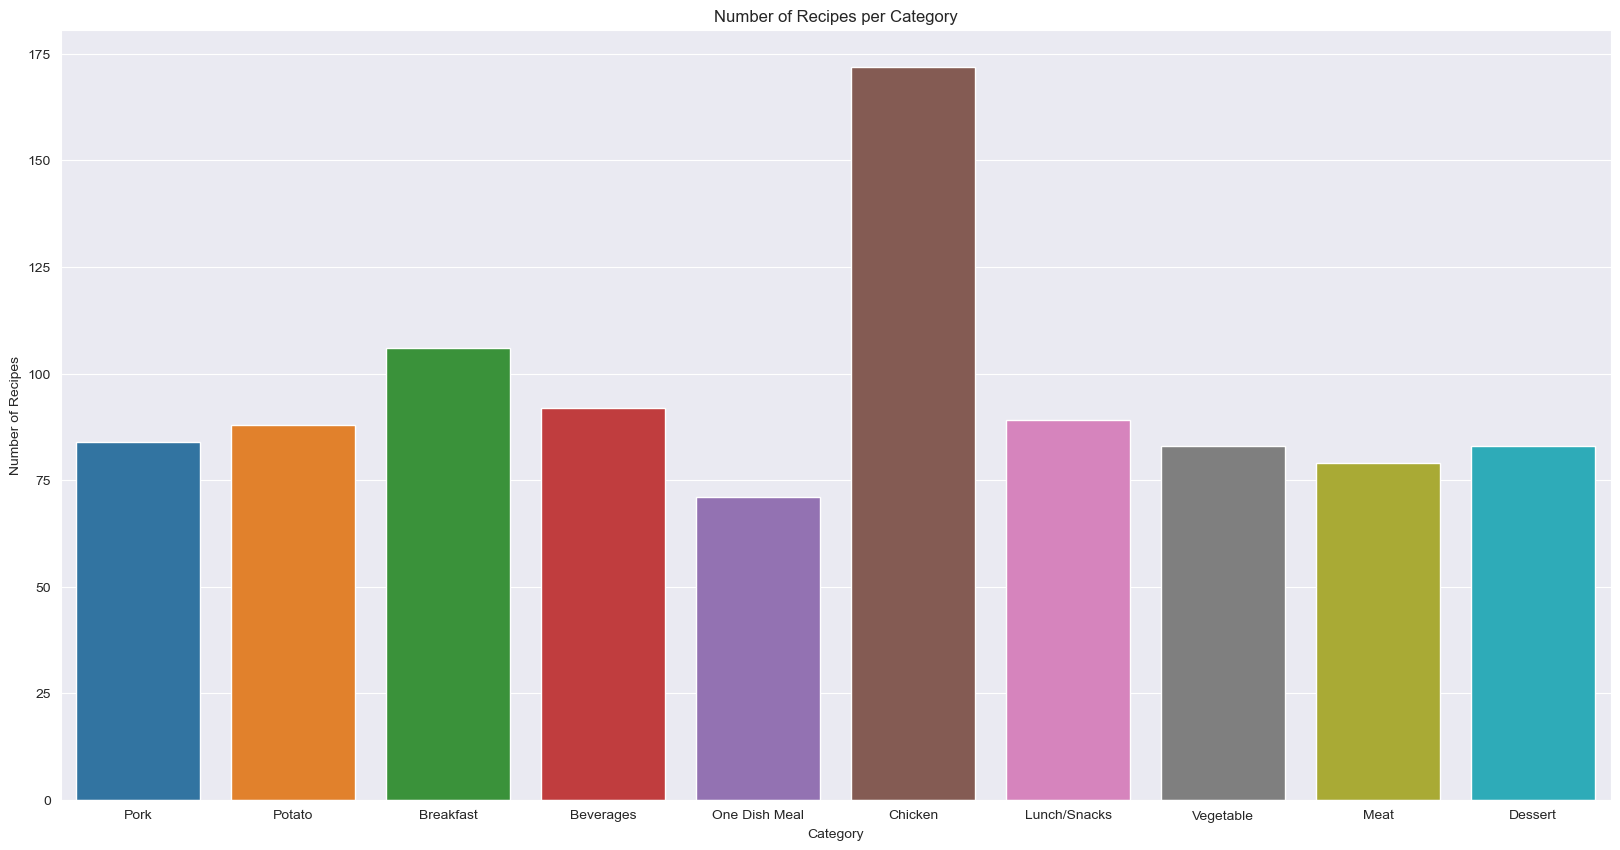

In [76]:
# Create a bar plot for category
sns.countplot(x='category', data=df)
plt.title('Number of Recipes per Category')
plt.xlabel('Category')
plt.ylabel('Number of Recipes')
plt.show()

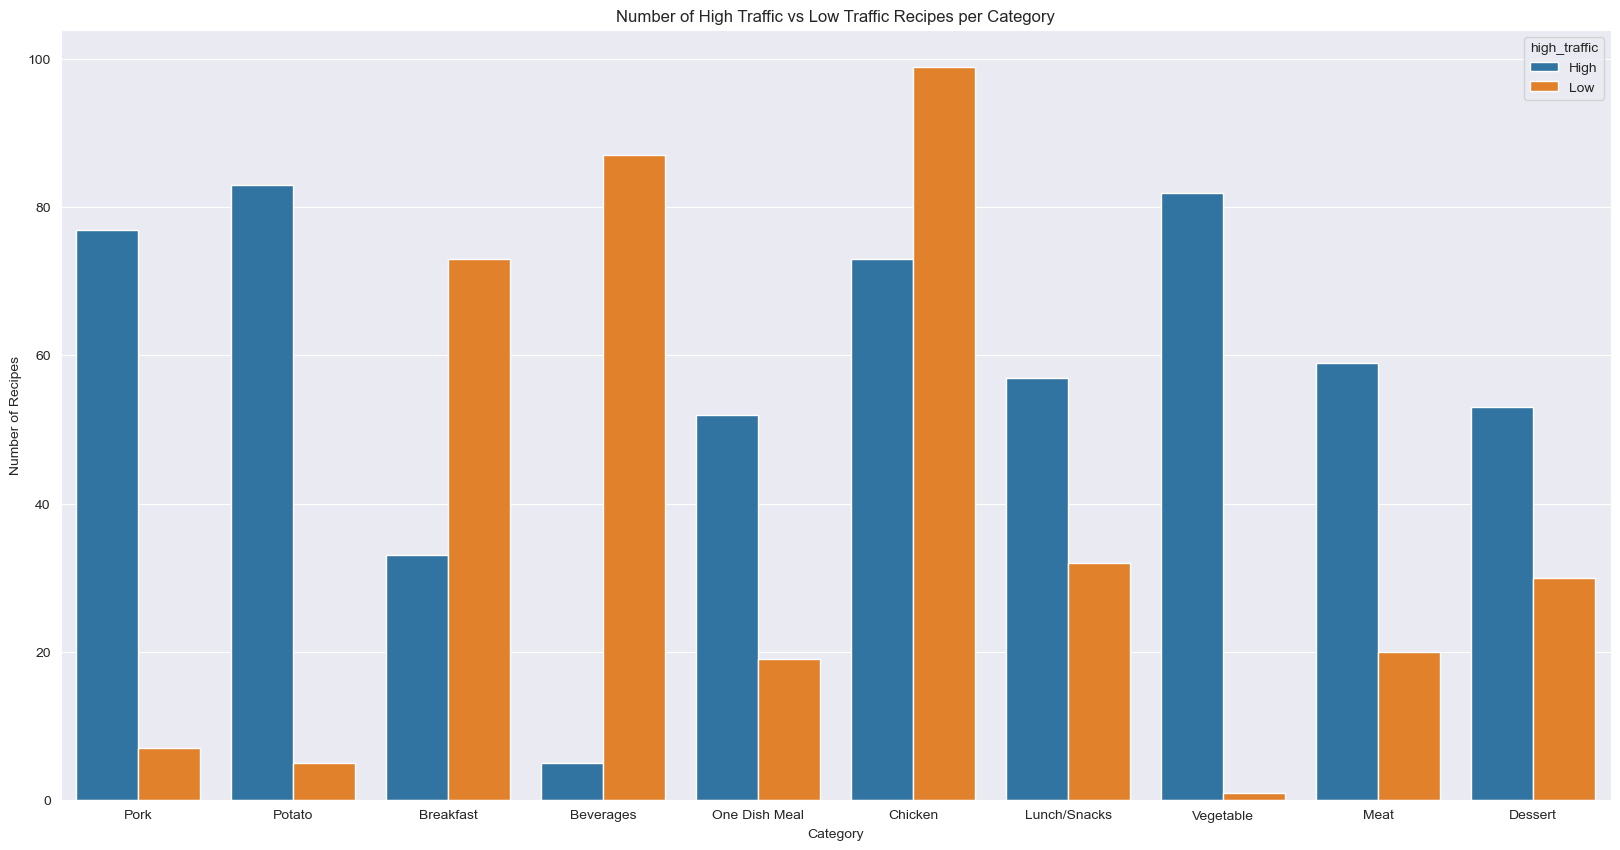

In [77]:
# Create a count plot
sns.countplot(x='category', hue='high_traffic', data=df)
plt.title('Number of High Traffic vs Low Traffic Recipes per Category')
plt.xlabel('Category')
plt.ylabel('Number of Recipes')
plt.show()

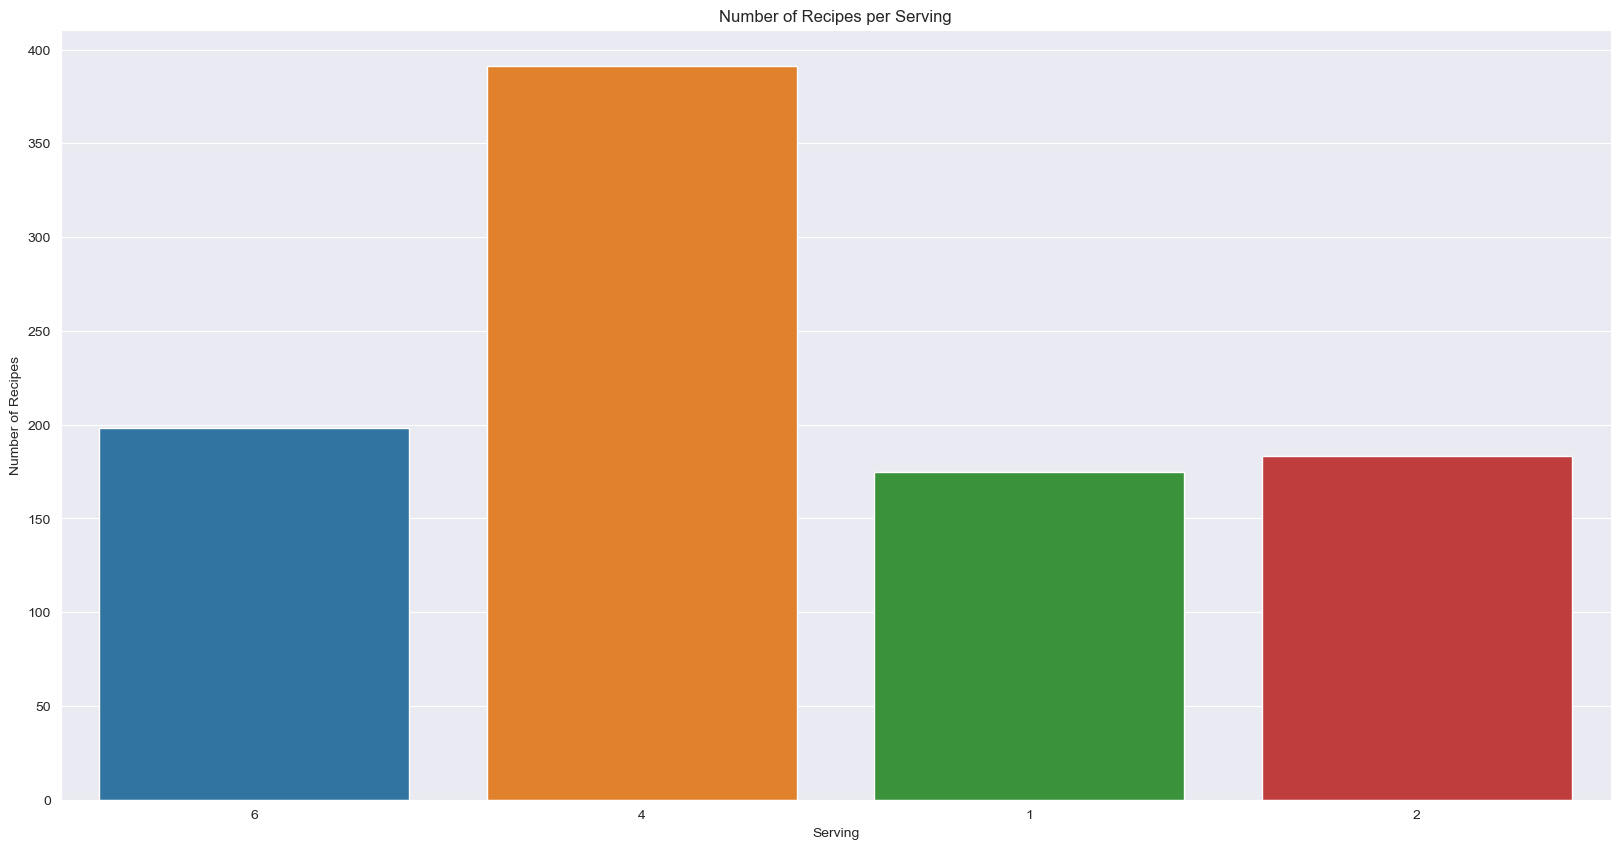

In [78]:
# Create a bar plot for servings
sns.countplot(x='servings', data=df)
plt.title('Number of Recipes per Serving')
plt.xlabel('Serving')
plt.ylabel('Number of Recipes')
plt.show()

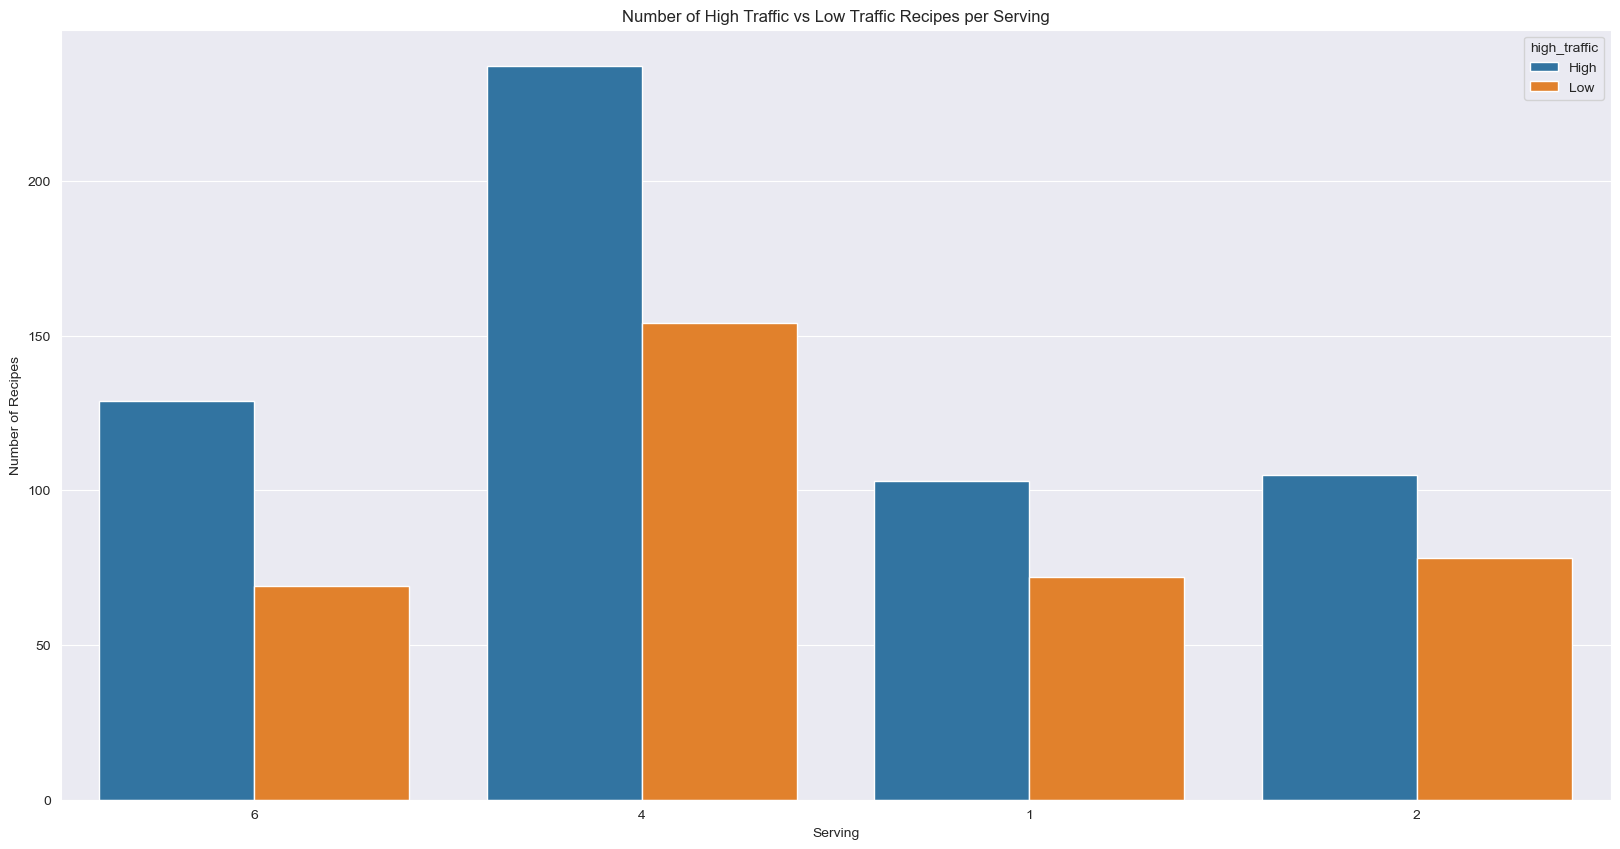

In [79]:
# Create a count plot for servings
sns.countplot(x='servings', hue='high_traffic', data=df)
plt.title('Number of High Traffic vs Low Traffic Recipes per Serving')
plt.xlabel('Serving')
plt.ylabel('Number of Recipes')
plt.show()

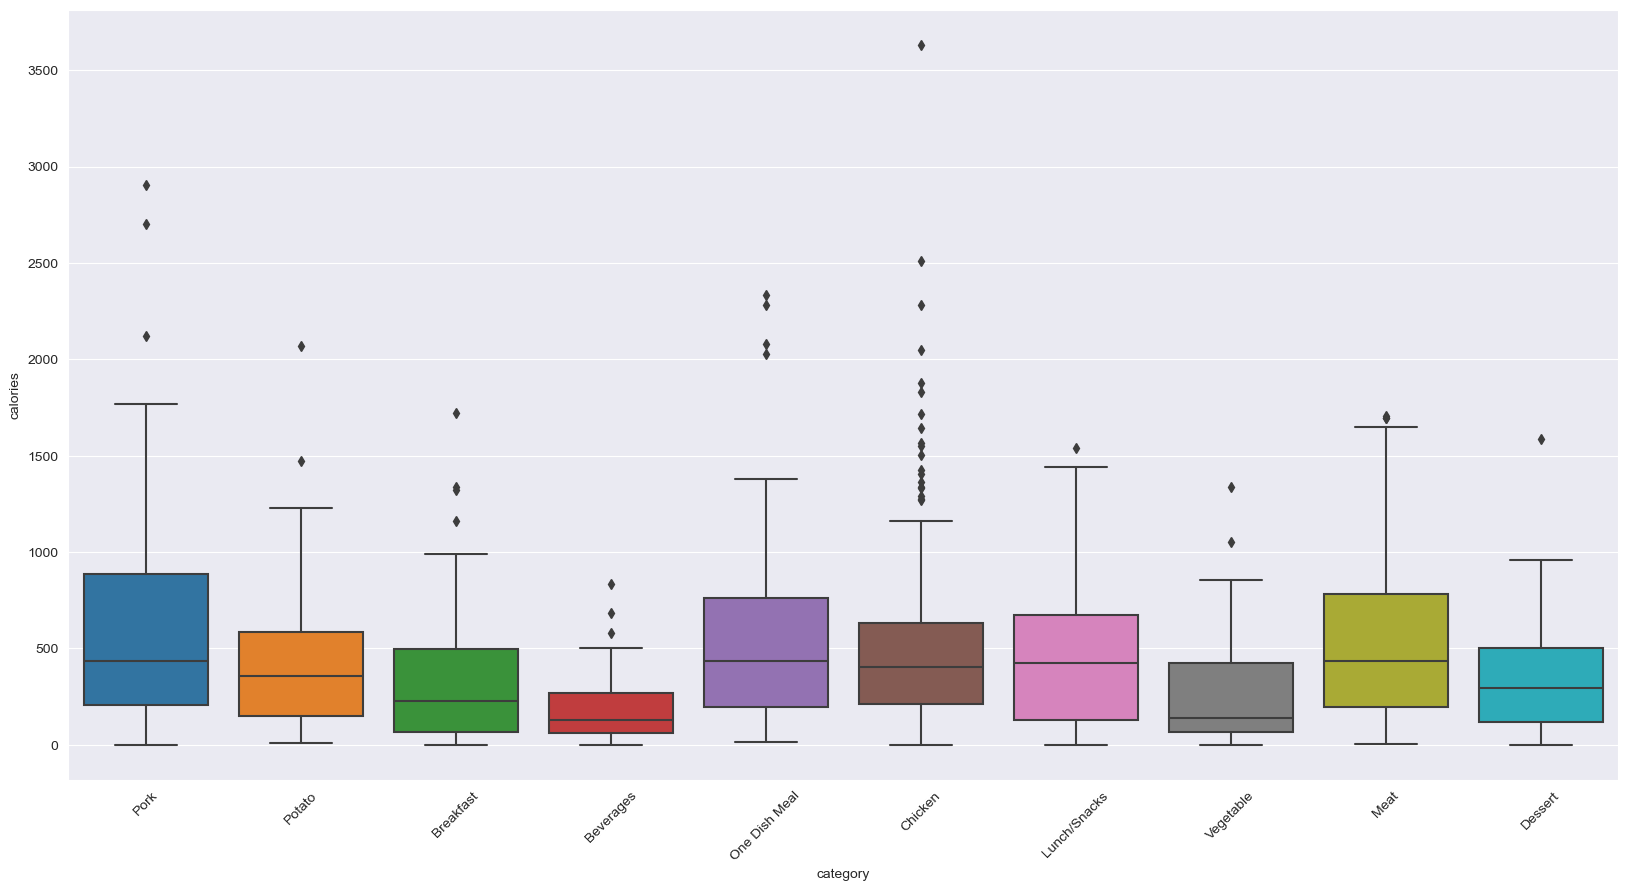

In [80]:
# Plot a boxplot of calories by category
sns.boxplot(data=df, x="category", y="calories")
plt.xticks(rotation=45)
plt.show()


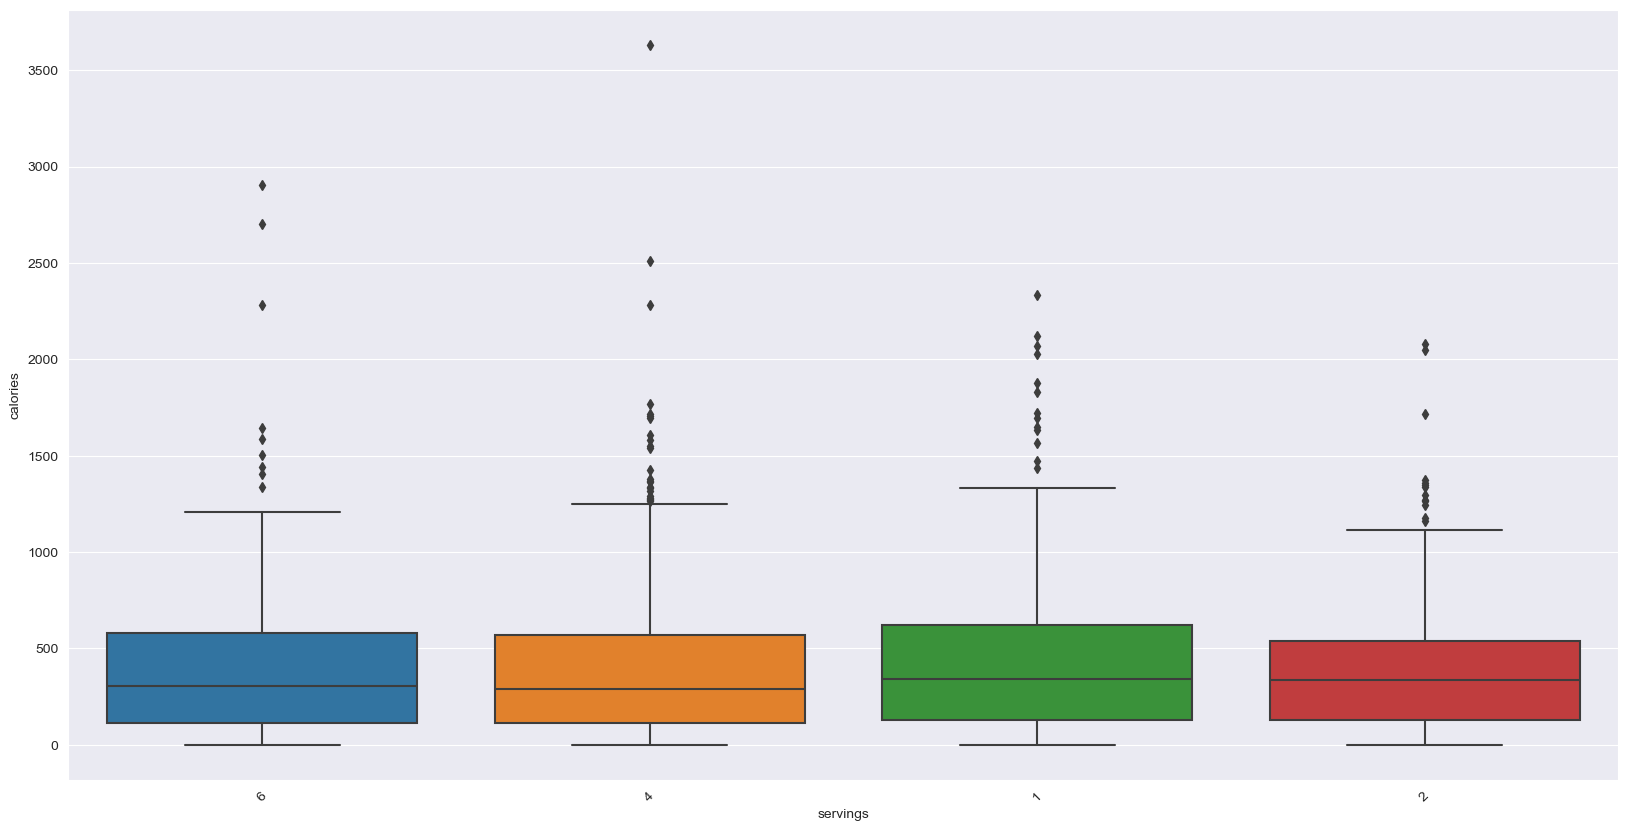

In [81]:
# Plot a boxplot of calories by servings
sns.boxplot(data=df, x="servings", y="calories")
plt.xticks(rotation=45)
plt.show()

## Data Processing
The outliers were treated by capping the values at Q3 + 3 IQR. The outliers were capped at the maximum value of the column.

The outliers were capped at the maximum value of the column because the outliers are not a result of a data entry error, but rather a result of the nature of the data. For example, the number of calories in a recipe can be very high, but it is not an error. The same applies to the number of carbohydrates, sugar, and protein in a recipe.

In [82]:
def replace_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    upper_bound = Q3 + 3 * IQR
    lower_bound = Q1 - 3 * IQR

    for column in df.columns:
        df[column] = np.where(df[column] > upper_bound[column], upper_bound[column], df[column])
        df[column] = np.where(df[column] < lower_bound[column], lower_bound[column], df[column])

    return df


In [83]:
# replace outliers
df[numeric_columns] = replace_outliers(df[numeric_columns])

In [84]:
# Scale the data
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [85]:
df['high_traffic'] = df['high_traffic'].replace({'High': 1, 'Low': 0})

In [86]:
# One-hot encode the data using pandas one-hot encoding
le = LabelEncoder()
df = pd.get_dummies(df.drop(columns=['recipe'], axis=1))
df.head()

,calories,carbohydrate,sugar,protein,high_traffic,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,servings_1,servings_2,servings_4,servings_6
0,0.222173,0.245161,0.284660,0.232820,1,False,False,False,False,False,False,False,True,False,False,False,False,False,True
1,0.018017,0.269582,0.020476,0.008870,1,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,0.466034,0.298408,0.097023,0.027766,0,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3,0.049395,0.213609,1.000000,0.000193,1,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,0.013719,0.012734,0.024886,0.005110,0,True,False,False,False,False,False,False,False,False,False,False,False,True,False


# Modeling

In [87]:
# split train and test data
X = df.drop(['high_traffic'], axis=1)
y = df['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

## Feature Engineering

### New Features

### Feature Selection

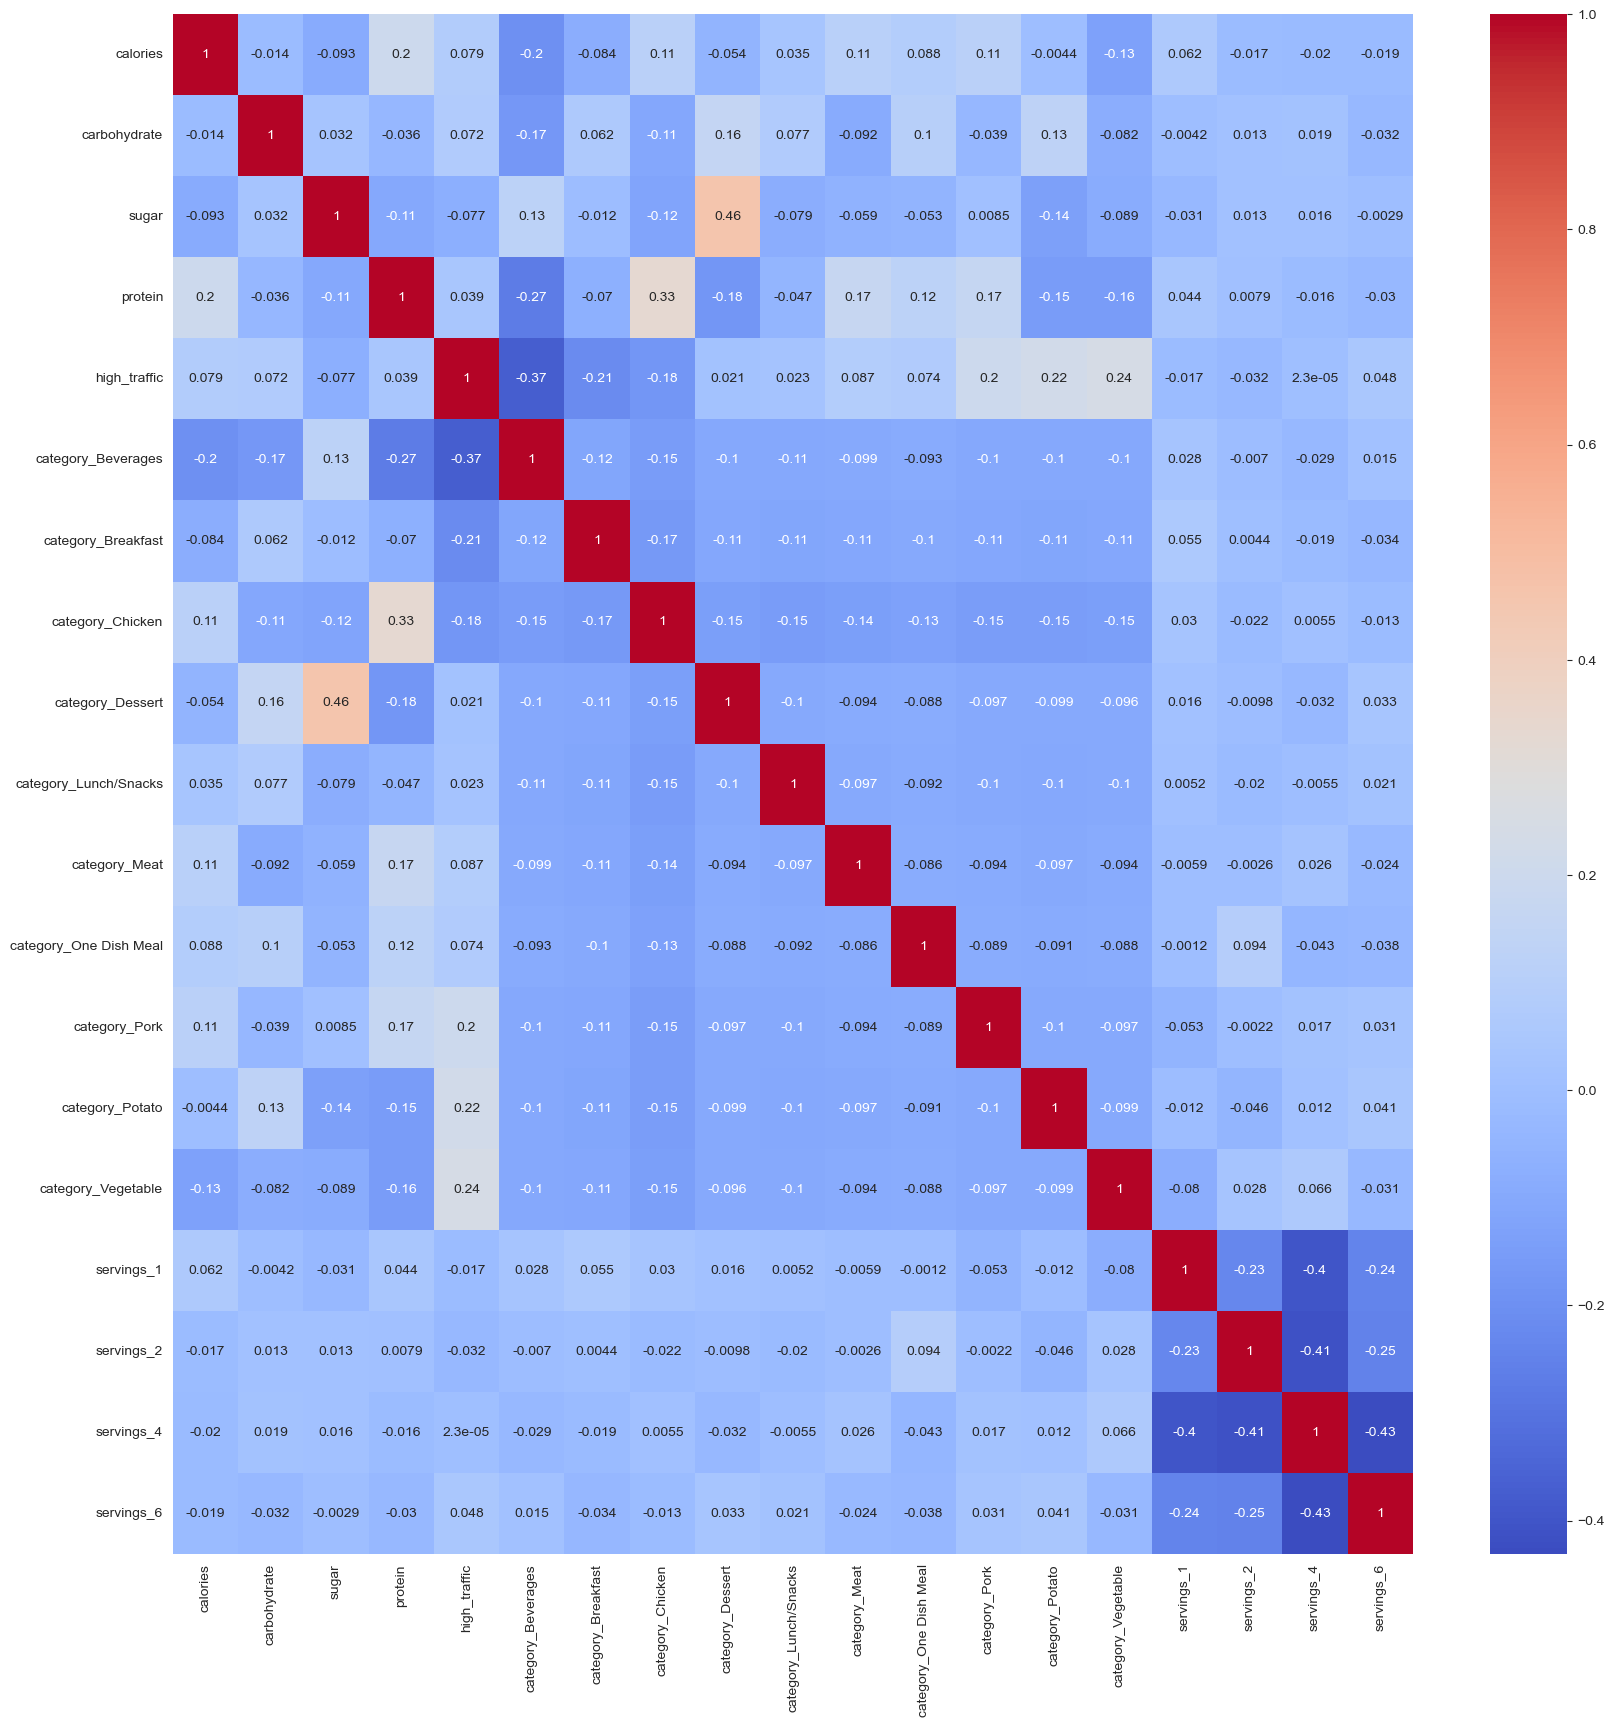

In [88]:
# correlation matrix for the features
corr = df.corr()
# plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

best_features = SelectKBest(k=5, score_func=f_classif)
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([df_columns, df_scores], axis=1)
featureScores.columns = ['Specs', 'Score']
main_feat = featureScores.nlargest(20, 'Score').set_index('Specs')
main_feat

## Model Selection

In [119]:
# create a function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test, data=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if data is None:
        data = []

    data.append([model.__class__.__name__,
                 accuracy_score(y_test, y_pred),
                 precision_score(y_test, y_pred),
                 recall_score(y_test, y_pred),
                 f1_score(y_test, y_pred),
                 roc_auc_score(y_test, y_pred)])

    return data


In [120]:
model_list = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(),
              DecisionTreeClassifier(), RandomForestClassifier()
    , LinearSVC(), Perceptron(), SGDClassifier(), SVC(), GradientBoostingClassifier(), XGBClassifier()
    , AdaBoostClassifier(), ExtraTreesClassifier()]

data = None
for model in model_list:
    data = evaluate_model(model, X_train, X_test, y_train, y_test, data)

print(tabulate(data, headers=["Model name", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC Score"]))

Model name                    Accuracy    Precision    Recall    F1 Score    ROC AUC Score
--------------------------  ----------  -----------  --------  ----------  ---------------
LogisticRegression            0.750877     0.78534   0.833333    0.808625         0.721429
KNeighborsClassifier          0.726316     0.771277  0.805556    0.788043         0.698016
GaussianNB                    0.694737     0.854962  0.622222    0.720257         0.720635
DecisionTreeClassifier        0.663158     0.730769  0.738889    0.734807         0.636111
RandomForestClassifier        0.726316     0.760204  0.827778    0.792553         0.690079
LinearSVC                     0.754386     0.795699  0.822222    0.808743         0.730159
Perceptron                    0.733333     0.765306  0.833333    0.797872         0.697619
SGDClassifier                 0.729825     0.711934  0.961111    0.817967         0.647222
SVC                           0.733333     0.765306  0.833333    0.797872         0.697619

## Parameter Tuning

In [134]:
# Parameter tuning for Random Forest Classifier
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [135]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
rf_grid_result = rf_grid_search.fit(X_train, y_train)
best_model_rf = rf_grid_search.best_estimator_
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best: 0.762958 using {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}


In [136]:
# Parameter tuning for SGD Classifier
param_grid_sgd = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1, 10, 100]
}

In [137]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
sgd_grid_search = GridSearchCV(SGDClassifier(), param_grid_sgd, scoring='accuracy', n_jobs=-1, cv=kfold, verbose=1)
sgd_grid_result = sgd_grid_search.fit(X_train, y_train)
best_model_sgd = sgd_grid_search.best_estimator_
print("Best: %f using %s" % (sgd_grid_result.best_score_, sgd_grid_result.best_params_))

Fitting 10 folds for each of 1500 candidates, totalling 15000 fits
Best: 0.771845 using {'alpha': 0.1, 'eta0': 1, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'penalty': 'l2'}


## Model Evaluation

In [139]:
# evaluate the best model
data = None
data = evaluate_model(best_model_rf, X_train, X_test, y_train, y_test, data)
data = evaluate_model(best_model_sgd, X_train, X_test, y_train, y_test, data)
print(tabulate(data, headers=["Model name", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC Score"]))

Model name                Accuracy    Precision    Recall    F1 Score    ROC AUC Score
----------------------  ----------  -----------  --------  ----------  ---------------
RandomForestClassifier    0.708772     0.732057  0.85        0.786632         0.658333
SGDClassifier             0.750877     0.78836   0.827778    0.807588         0.723413


# Report

### Conclusion

From: Daniil To: Head of Data Science Subject: Report on the assigned project

1) Data Validation First, of all after uploading the data it was found that it contains 52 NaN values in calories, carbohydrate, sugar, protein. I tried to use KNN imputer, however it didn't work out well, so I abandoned the idea as the results of the model turned out to be worse, so the decision was to drop 52 missing rows. High traffic also has missing values but in this case, it is not missing at random, so I just replaced NA values with Not High. Backlog of changes: calories - NA rows, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax carbohydrate - NA rows dropped, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax sugar - NA rows dropped, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax protein - NA rows dropped, extreme outliers (Q3 + 3 IQR) were capped, scaled using MinMax category - 'Chicken Breast' values for changed to 'Chicken', then columns were one hot encoded servings - 2 values contained 'as a snack', they belonged to Lunch/Snack category so 'as a snack' was removed, the column was transformed to float 64 high_traffic - NaN values were replaced with 'not high' and then changed to 1 - high, 0 - not high

2) Exploratory Analysis Not to overload report I will ask you to refer to the graphs that will be enclosed below my report in the c. First, after plotting histograms of our numeric variables (calories,carbohydrate, sugar, protein,protein) we can clearly observe that data is skewed left with some outliers that will be later capped. Also, as for the largest number of categories observed from count plot we can see that chicken, brekfast, beverages have the most recipes. Second, judging from category by traffic graphic, we observe that the categories like vegetable, potato have the highest traffic labels, on the other hand beverages, beverages, breakfast contain a lot of not high labels. This gives good sense of what categories maybe popular and not. Third, after looking at barplots of high traffic vs numeric columns, we may conclude that on average the larger number of serving, calories, carbohydrate, protein results in high traffic, sugar has the opposite affect: on average if we have more sugar it results in low traffic Fourth, after having a look at correlation heat map we can observe different correlations for our categories: category_Beverages = -0.38, category_Vegetable = 0.25, category_Potato = 0.22, category_Breakfast = -0.21. Which confirms our findings from the second step.

4) Model Development We can be sure that it is classification problem. Here we predict if the recipe shown will result in 1 high traffic, 0 - not high traffic. At first, I ran LogisticRegression, KNeighborsClassifier,GaussianNB, DecisionTreeClassifier,RandomForestClassifier ,LinearSVC, Perceptron, SGDClassifier. Cross Validation (k=10) F1, precision and recall over 80% were the main metrics to assess the quality of the models. Based on these metrics I've chosen three models LogisticRegression, LinearSVC, SGDClassifier. However, LinearSVC seems to replicate the results of logistic regression. So as a base model I left only LogisticRegression and SGDClassifier as comparison model.

5) Model Evaluation

Logistic Regression CV f1 score is 0.7979 CV precision is 0.797 CV recall is 0.8014

Stochastic Gradient Descent Classifier CV f1 score is 0.7738 CV precision is 0.7616 CV recall is 0.8952

As we see from the results of model evaluation Logistic Regression is more balanced and outperforms Stochastic Gradient Descent Classifier. What we want is the highest precision with decent recall. Stochastic Gradient Descent Classifier has great recall, but in this case it matters less than precision.

After that GridSearchCV with StratifiedKFold was employed to improve the results of the models. They turned out to arrive to the same results on our test data. (Interesting fact Stochastic Gradient Descent Classifier outperformed LogReg on CV after improvement) Logistic Regression best params {'C': 0.1, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'} SGD Classifier params {'alpha': 0.01, 'l1_ratio': 1, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elastic-net'}

Precision = 0.82 Recall = 0.80 F1 = 0.81

Final answer: both LogisticRegression and Stochastic Gradient Descent Classifier can be used for this taks. I would opt for Stochastic Gradient Descent Classifier because it is more computationally efficient, however if interpretability is important, logistic regression may be a better choice. Here we would choose LogisticRegression to create understandable metric.

6) Business Metrics As per business to track the performance we will create high traffic rate: Use LogisticRegresion that I developed to calculate the probabilities of high traffic for each input. Average out these probabilities to get the final metric. The idea behind it is to increase high traffic rate, the ideal situation if we have high traffic rate = 1. However, it is not possible, because it will literally mean that each recipe high traffic. But the business objective is to get this metric as high as we can. Right now the metric is 0.52. Not bad but can be improved.

7) Final summary. In conclusion, the main recommendations are


### Recommendations


- Show categories that have great positive correlation such as vegetable, potato recipes
- Show less categories that have less positive correlation such as beverages, breakfast
- Show more recipes that have more servings, good on calories, protein and carbohydrate and contain less sugar. ('healthy recipes')
- Collect data on missing values to improve the performance of the model